# Import libraries

In [1]:
import pandas as pd
import numpy as np

#for text pre-processing
import re, string
import nltk
import contractions
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc, roc_auc_score

# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Gamer\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Gamer\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Gamer\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Gamer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Preprocess data

In [2]:
df = pd.read_csv(r"C:\Users\Gamer\Documents\PERSONAL\Job_title_prediction\job_postings.csv")
df2 = pd.read_csv(r"C:\Users\Gamer\Documents\PERSONAL\Job_title_prediction\job_summary.csv")

df = df[["job_link","job_title"]]
df.head()

,job_link,job_title
0,https://www.linkedin.com/jobs/view/senior-mach...,Senior Machine Learning Engineer
1,https://www.linkedin.com/jobs/view/principal-s...,"Principal Software Engineer, ML Accelerators"
2,https://www.linkedin.com/jobs/view/senior-etl-...,Senior ETL Data Warehouse Specialist
3,https://www.linkedin.com/jobs/view/senior-data...,Senior Data Warehouse Developer / Architect
4,https://www.linkedin.com/jobs/view/lead-data-e...,Lead Data Engineer


In [3]:
df_merge = pd.merge(df,df2,on="job_link",how="right")
df_merge = df_merge.drop(columns="job_link")
df_merge.head()

,job_title,job_summary
0,Senior Machine Learning Engineer,Company Description\nJobs for Humanity is part...
1,"Principal Software Engineer, ML Accelerators",Who We Are\nAurora (Nasdaq: AUR) is delivering...
2,Senior ETL Data Warehouse Specialist,"Location: New York City, NY\nPosition Summary\..."
3,Senior Data Warehouse Developer / Architect,Responsibilities:\nCandidate must have signifi...
4,Lead Data Engineer,Dice is the leading career destination for tec...


In [4]:
df_merge[["job_title","job_summary"]] = df_merge[["job_title","job_summary"]].apply(lambda col:col.str.lower())
df_merge.head()

,job_title,job_summary
0,senior machine learning engineer,company description\njobs for humanity is part...
1,"principal software engineer, ml accelerators",who we are\naurora (nasdaq: aur) is delivering...
2,senior etl data warehouse specialist,"location: new york city, ny\nposition summary\..."
3,senior data warehouse developer / architect,responsibilities:\ncandidate must have signifi...
4,lead data engineer,dice is the leading career destination for tec...


In [5]:
top_30_job_title = df_merge["job_title"].value_counts().head(30)
print(top_30_job_title)
print(f"Total: { df_merge.shape[0] }, top 30: {top_30_job_title.sum()}")

job_title
senior data engineer                                                    288
senior data analyst                                                     165
data engineer                                                           150
data analyst                                                            140
senior mlops engineer                                                   138
data scientist                                                          128
lead data engineer                                                      123
senior data scientist                                                   119
data architect                                                          115
staff machine learning engineer, series a                               101
senior machine learning engineer                                         59
manager, data engineering                                                57
manager, data loss prevention (dlp) engineer (symantec)                  57
se

In [6]:
print(df_merge["job_title"].str.count("manager").sum())
print(df_merge["job_title"].str.count("senior").sum())

1650
2748


In [7]:
df_merge["job_title"] = df_merge["job_title"].apply(lambda title: "manager" if "manager" in title else "engineer")
df_merge.head(20)

,job_title,job_summary
0,engineer,company description\njobs for humanity is part...
1,engineer,who we are\naurora (nasdaq: aur) is delivering...
2,engineer,"location: new york city, ny\nposition summary\..."
3,engineer,responsibilities:\ncandidate must have signifi...
4,engineer,dice is the leading career destination for tec...
5,engineer,department\nf&a its - business intelligence so...
6,manager,company description\njobs for humanity is part...
7,engineer,company description\njobs for humanity is part...
8,engineer,enterprise technology/telecom is looking for s...
9,engineer,jd:\nresponsibilities\ndesign and develop syst...


<Axes: xlabel='job_title'>

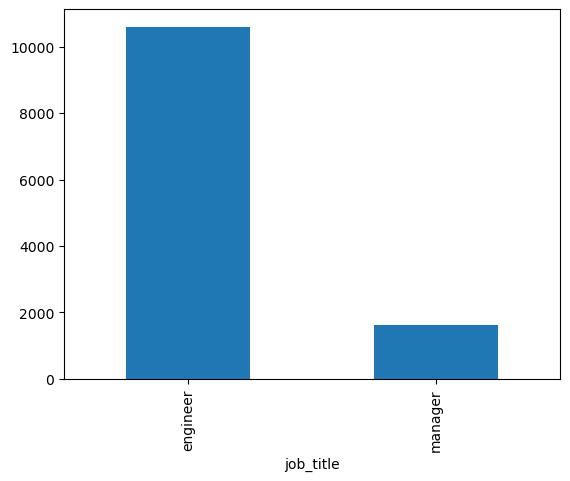

In [8]:
df_merge["job_title"].value_counts().plot(kind="bar")

In [9]:
example = df_merge["job_summary"][5]
print(example)

department
f&a its - business intelligence solutions
about the department
it services collaborates with campus partners to support the mission of the university of chicago through the consistent delivery of high-quality solutions and services.
we provide secure, stable, and reliable infrastructure and applications to support the mission of the university.
we support and enable faculty research and teaching with the effective use of technology.
we simplify the technology experience for faculty, students, alumni, and staff, and we ensure technology is mobile-friendly and accessible.
we identify, manage, and mitigate the technology risks of the university.
job summary
the senior data engineer is the technical lead on projects to design, develop, and qa data warehouse (dw) and extract/transform/load (etl) environments, and other database environments, to enable analytics. this role follows the prescribed project and development methodology. under the direction of a project manager, this ro

# Text Preprocessing

In [10]:
# Remove special characters
def remove_spec_chars(text):
    return re.sub(r'[\.\?\!\,\:\;\&\/\(\)\+\-\'\$\+\’\@\%]', ' ', text)

# Remove stopwords (this, a, an)
stop_words = set(stopwords.words('english'))

def stopword(text):
    
    # Step 1: Tokenize the input string into words
    words = text.split()
    
    # Step 2: Filter out the stopwords
    filtered_words = []
    for word in words:
        if word not in stop_words:
            filtered_words.append(word)
    
    # Step 3: Join the filtered words back into a single string
    result = ' '.join(filtered_words)
    return result

# Remove numbers
def numbers(text):
    return re.sub(r'\d',' ', text)

# Remove whitespace
def whitespace(text):
    return " ".join(text.split())
    #return text.strip()

# Lemmatize
wl = WordNetLemmatizer()
text = "Hello my name's Kristof Dome and I'm here to do some interesting things today"

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get PoS tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the PoS tag and lemmatize the word/token
    return " ".join(a)

def contract(string):
    return contractions.fix(string)

df_merge["clean_text"]=df_merge["job_summary"].apply(contract).apply(remove_spec_chars).apply(stopword).apply(numbers).apply(whitespace).apply(lemmatizer)
example = df_merge["clean_text"][5]
print(example)
#TODO: Use contractions before removing special charactes. Then at the end apply the lemmatizer

department f business intelligence solution department service collaborate campus partner support mission university chicago consistent delivery high quality solution service provide secure stable reliable infrastructure application support mission university support enable faculty research teach effective use technology simplify technology experience faculty student alumni staff ensure technology mobile friendly accessible identify manage mitigate technology risk university job summary senior data engineer technical lead project design develop qa data warehouse dw extract transform load etl environment database environment enable analytics role follow prescribe project development methodology direction project manager role work closely lead architect bi lead dw developer source application developer subject matter expert smes senior data engineer support maintain enhance environment achieve cross functional integrated reporting analysis environment university user responsibility work 

# Vectorization / Word embedding (text -> numerical)

## Train-test split

In [11]:
#TODO: vectorize database OR find most common terms, extract them
X_train, X_test, y_train, y_test = train_test_split(df_merge["clean_text"],df_merge["job_title"],test_size=0.2,shuffle=True)

X_train_tok = []
X_test_tok = []

for text in X_train:
    text_tok = nltk.word_tokenize(text)
    X_train_tok.append(text_tok)

for text in X_test:
    text_tok = nltk.word_tokenize(text)
    X_test_tok.append(text_tok)

## Vectorization

In [12]:
#Visualizing datasets
print(X_train_tok[2])
print(y_train[2])

['job', 'description', 'medical', 'technologist', 'analyze', 'bodily', 'fluid', 'check', 'disease', 'abnormality', 'work', 'hospital', 'lab', 'private', 'practice', 'outpatient', 'center', 'healthcare', 'facility', 'collect', 'blood', 'urine', 'sample', 'analyze', 'sample', 'maintain', 'equipment', 'handle', 'patient', 'data', 'play', 'critical', 'role', 'maintain', 'sterile', 'condition', 'prevent', 'disease', 'help', 'patient', 'provider', 'find', 'answer', 'various', 'health', 'concern', 'minimum', 'requirement', 'least', 'year', 'recent', 'experience', 'medical', 'technologist', 'ascp', 'amt', 'hew', 'aab', 'certification', 'bls', 'certification', 'aha', 'current', 'state', 'license', 'applicable', 'benefit', 'benefit', 'take', 'travel', 'ally', 'job', 'cross', 'country', '*', 'include', 'private', 'housing', 'generous', 'housing', 'allowance', 'comprehensive', 'health', 'insurance', 'prescription', 'coverage', 'dependent', 'health', 'insurance', 'prescription', 'coverage', 'compet

In [13]:
#Tf-Idf
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train) 
X_test_vectors_tfidf = tfidf_vectorizer.transform(X_test)
print(X_train_vectors_tfidf[2])

  (0, 7858)	0.06407438784993998
  (0, 24152)	0.059947816646520324
  (0, 7168)	0.09584672787984261
  (0, 4958)	0.12516534646916744
  (0, 32544)	0.11303079061621268
  (0, 5265)	0.15400269921861376
  (0, 12436)	0.12714420302271093
  (0, 8412)	0.1262779078241213
  (0, 8815)	0.06694904983490058
  (0, 26213)	0.0801655544721496
  (0, 3775)	0.058758788686684216
  (0, 26081)	0.09821922920084108
  (0, 6213)	0.052814211037051785
  (0, 8393)	0.08612539283032514
  (0, 7025)	0.15262319361616591
  (0, 24459)	0.23201954190109084
  (0, 15961)	0.11706117272881067
  (0, 6287)	0.05346694752422061
  (0, 14629)	0.24539915952560615
  (0, 6987)	0.06662179153277512
  (0, 7239)	0.05557649353132632
  (0, 1201)	0.12289508252174433
  (0, 1774)	0.055606394786106184
  (0, 18019)	0.08179118857950428
  (0, 29560)	0.04456377184463142
  :	:
  (0, 30537)	0.05368573416215939
  (0, 7214)	0.0528759906312714
  (0, 27064)	0.033277560767061426
  (0, 8464)	0.04482211788234868
  (0, 17919)	0.02259891720560867
  (0, 28408)	0.0451

# Model implementation

In [14]:
# TODO: Use 1. logistic regression 2. SVM 3. Custom NN 

print(f"Testing database size: {y_test.shape[0]} \n"
f"Training database size: {y_train.shape[0]} \n"
f"Number of features (unique words): {X_train_vectors_tfidf.shape[1]}")

Testing database size: 2444 
Training database size: 9773 
Number of features (unique words): 34992


In [24]:
#Initilize log. reg. model
logres_model=LogisticRegression(solver = 'sag', C=20)

#Apply model on training database
logres_model.fit(X_train_vectors_tfidf, y_train)  

#Class predictions ("engineer" (0) or "manager" (1))
y_predict = logres_model.predict(X_test_vectors_tfidf)
#Probabilistic predictions (0 to 1 for each class - only get probabilities for class 0 (engineeer) in this case)
y_prob = logres_model.predict_proba(X_test_vectors_tfidf)[:,0]

print("Fist 5 examples (probabilistic prediction wrt. engineers), (classiciation of each job description)")
print(f"{y_prob[:5]} {y_predict[:5]}")

Fist 5 examples (probabilistic prediction wrt. engineers), (classiciation of each job description)
[0.9947988  0.99918178 0.98428569 0.99946145 0.88997141] ['engineer' 'engineer' 'engineer' 'engineer' 'engineer']


# Data visualization

              precision    recall  f1-score   support

    engineer       0.96      0.98      0.97      2117
     manager       0.88      0.73      0.80       327

    accuracy                           0.95      2444
   macro avg       0.92      0.86      0.89      2444
weighted avg       0.95      0.95      0.95      2444

Model accuracy: 95.04909983633388

Confusion Matrix:


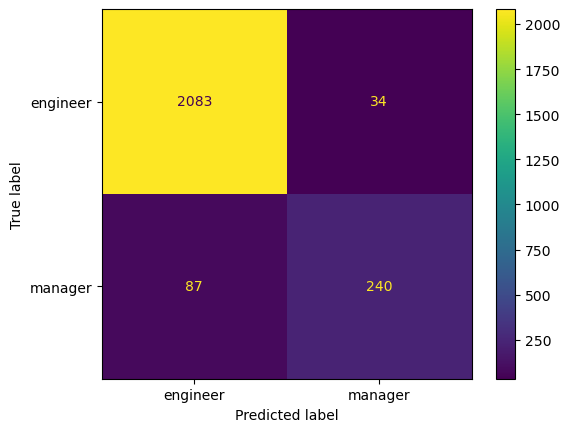

In [25]:
# Compare accuracy, confusion matrix.
# Use PowerBI to visualize all kinds of other data.
#Create classification report
print(classification_report(y_test,y_predict))
cm = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logres_model.classes_)
print(f"Model accuracy: {classification_report(y_test,y_predict, output_dict=True)["accuracy"]*100}\n")
print('Confusion Matrix:')
disp.plot()

#TODO: Graphically represent classification instances. Create a NN and compare the results.